### Importing needed libraries

In [1]:
import time
import numpy as np
from scipy.io import wavfile as wav
import IPython.display as ipd
import pandas as pd
import librosa
import librosa.display as lid
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import sounddevice as sd

### Defining all our helping function

In [2]:
#This function Does the following:
# 1) If stereo --> Mono by mean
# 2) Low Pass Filter cut at given threshold
# 3) Normalize between -1 and 1
# 4) Apply sin(pi/2 * x) function to improve loudness and richness of the sound 
def preprocessAudio(audio):
    if len(audio.shape) != 1:                                        
        audio = np.mean((audio[:,0],audio[:,1]),axis=0)
    # FILTER
    FFT = np.fft.rfft(audio)
    freq = np.linspace(0,(rate/2),len(FFT))
    cutInd = np.where(freq > cutLow)[0][0]
    FFT[0:cutInd] = 0
    audio = np.fft.irfft(FFT)
    #Normalize and compressor
    audio = 2.*(audio + np.abs(np.min(audio)))/np.ptp(audio)-1
    audio = np.sin(1.57075*audio)
    return(audio)


def splitAudio(audio):
    if len(audio.shape) != 1:                                        
        audio = np.mean((audio[:,0],audio[:,1]),axis=0)
    steps = int(np.floor((len(audio)/rate/secondStep)))   #Calculate floor steps count
    audio = np.array(audio[0:steps*rate*secondStep])
    audio = np.array(np.split(audio,steps))
    return(audio)
    
def shuffleAudio(audio):
    audio = shuffle(audio)
    steps = audio.shape[0]
    TTidx = int(steps*.7)                                           #Split percentage declared here
    audioTrain = audio[0:TTidx]
    audioTest  = audio[TTidx:steps]
    return(audioTrain, audioTest)

def shuffleAndSplitAudio(audio):
    return shuffleAudio(splitAudio(audio))

#This function augment the data with some random factors
#We have 3 possible transform, random noise within a given factor
#Random Stretch within a given factor
#Random Pitch shift
#The function randomly select 1/2 or all 3 transformation to be applied to the original audio
#And the it return the original audio concatenated with the augmented one
def augmentData(audio, noise_factor=0.03,stretch_factor=0.4):   
    audioAugmented = audio
    choice = np.random.randint(1,8)
    if choice in [1,4,6,7]:
        audioAugmented    = audio + np.random.uniform(0,noise_factor) *np.random.normal(0,1,len(audioAugmented))
    if choice in [2,4,5,7]:
        stretch = np.random.uniform(-stretch_factor,stretch_factor)
        audioAugmented    = librosa.effects.time_stretch(audioAugmented,(1+stretch))
        if stretch > 0:               #To return a sample of sampling-rate length even when stretching is applied
            audioAugmented = np.concatenate((audioAugmented,np.zeros((rate*secondStep)-len(audioAugmented)))) #Adding zeros to the end if stretch is positive
        if stretch < 0:
            audioAugmented = audioAugmented[0:(rate*secondStep)]   
    if choice in [3,5,6,7]:
        audioAugmented    = librosa.effects.pitch_shift(audioAugmented,rate,n_steps=np.random.randint(-2,3))
    return(np.hstack((audio,audioAugmented)))

#Main function that calls the other ones
def audioToSplit(audio1, audio2, audio3, setName):
    #Extracting features and label
    audio1Data, audio1Label = processAudio(audio1,0,setName)
    audio2Data, audio2Label = processAudio(audio2,1,setName)
    audio3Data, audio3Label = processAudio(audio3,2,setName)

    data = np.concatenate((audio1Data,audio2Data,audio3Data))
    label = np.concatenate((audio1Label,audio2Label,audio3Label))
    #Shuffle / One-Hot Encoding
    label = keras.utils.to_categorical(label, 3)                   #One Hot Encoding
    data, label = shuffle(data,label)
    return(data,label)


def processAudio(audio,label,setName):
    data = []
    # In this function we preprocess and extract mfcc features for every sample
    # If we are processing Training set we will apply data augmentation to our samples
    if(setName == 'Train'):
        # For each Sample of secondStep length we take the sample and we augment the data
        # Then we extract the mfcc for the original sample and the augmented ones
        for i in range(0,audio.shape[0]):  
            audioSample = audio[i]
            audioSample = augmentData(audioSample)
            augStep = int((len(audioSample)/rate)/secondStep) 
            for j in range(0,(augStep)):
                audioSamplePiece = audioSample[(rate*(secondStep*j)) : (rate*(secondStep*(j+1)))]
                audioSamplePiece = preprocessAudio(audioSamplePiece)
                data.append( getFeatures( audioSamplePiece))
    #Test set processing just extract the mfcc for every sample
    elif(setName == 'Test'):
        for i in range(0,audio.shape[0]):
            audioSample = audio[i]
            audioSample = preprocessAudio(audioSample)
            data.append(getFeatures(audioSample))  
    else:
        print('Wrong set name')
        return None
    data = np.expand_dims(data, axis=-1)                             
    label = np.full(len(data), label)              
    return data, label
 
#MFCC is defined with 44 coefficients so that one second of audio will be reduced to a dimension of 44x44
#Making it a perfect rectangle, more suited for a convolutional model, increasing the number of coefficients
#Also improves the accuracy
def getFeatures(audio):
    return librosa.feature.mfcc(audio, sr=rate,n_mfcc=44)


## Lables and function used to output different kinds of prediction based on argument
## given ad audio file this function split and process the data into samples
## for each sample gives a prediction and then the most frequent prediction is used
## as a prediction for the whole audio clip, passing different arguments we can chose
## to have all the info, just the audio or just the prediction

labels = {0 : 'Jinping', 1 : 'Putin', 2 : 'Obama', 3 : 'Unknown'}

def getPrediction(myrec, arg='all'):
    audio = splitAudio(myrec)
    predData, _ = processAudio(audio,0,'Test')
    samples = predData.shape[0]
    pred = []
    for i in range(0,samples):
        a = np.expand_dims(predData[i],axis=0)
        pred.append(np.argmax(model.predict(a)))
    if arg == 'audio':
        print(pred, '\nSpeaker -> ',labels[np.argmax(np.bincount(pred))])
        filtred = preprocessAudio(myrec)
        return filtred
    if arg == 'all':
        print(pred, '\nSpeaker -> ',labels[np.argmax(np.bincount(pred))])
        filtred = preprocessAudio(myrec)
        plt.plot(filtred)
        return filtred
    elif arg == 'value':
        return int(np.argmax(np.bincount(pred)))

### Preparing the data for the model

In [3]:
#Defining global variables
rate            = 22050
num_classes     = 3
secondStep      = 1     #Length in seconds of each Sample
cutLow          = 200   #LowPass filter Hz threshold

#Loading audio files
_, audio1   = wav.read('Jinping.wav')
_, audio2   = wav.read('Putin.wav')
_, audio3  = wav.read('Obama.wav')

<ipython-input-3-435724cdc107>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, audio1   = wav.read('Jinping.wav')
<ipython-input-3-435724cdc107>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, audio2   = wav.read('Putin.wav')
<ipython-input-3-435724cdc107>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, audio3  = wav.read('Obama.wav')


In [4]:
%%time
#Shuffle / Split Training / Test Audio
print('Shuffling and splitting audio files...')
Train1,Test1   = shuffleAndSplitAudio(audio1*1.0)
Train2,Test2   = shuffleAndSplitAudio(audio2*1.0)
Train3,Test3   = shuffleAndSplitAudio(audio3*1.0)

#Creating Augmented Training set
print('Creating augmented training data and split...')
x_train, y_train = audioToSplit(Train1,Train2,Train3,'Train')

#Creating Test set
print('Creating testing data and split...')
x_test, y_test = audioToSplit(Test1,Test2,Test3,'Test')

Shuffling and splitting audio files...
Creating augmented training data and split...
Creating testing data and split...
Wall time: 26.7 s


In [5]:
print('train examples:\t',x_train.shape[0],'\ntest examples\t',x_test.shape[0])

train examples:	 1266 
test examples	 273


In [6]:
x_train.shape

(1266, 44, 44, 1)

### Model deploy / train / validation

In [12]:
input_shape = x_train.shape[1:]
#Declaring, compiling, and running the model
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape, name='input'),
        
        keras.layers.Conv2D( 16,(3,3), padding="same",activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
        
        keras.layers.Conv2D( 32,(3,3), padding="same",activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
        
        keras.layers.Conv2D( 64,(3,3), padding="same",activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(100,kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=keras.regularizers.l2(1e-4),activity_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(100,kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=keras.regularizers.l2(1e-4),activity_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 44, 44, 16)        64        
_________________________________________________________________
average_pooling2d_6 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
average_pooling2d_7 (Average (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)       

### Fast training stage

In [13]:
%%time
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=100,
          verbose=3,
          validation_data=(x_test,y_test)
         )

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

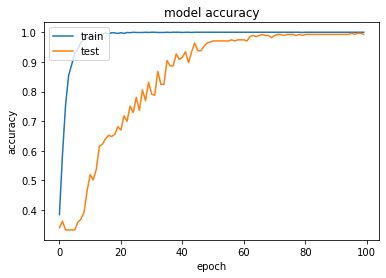

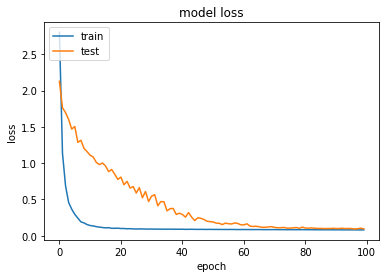

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Slow training stage

Epoch 1/25
3/3 [==============================] - 2s 329ms/step - loss: 0.0812 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9927
Epoch 2/25
3/3 [==============================] - 0s 48ms/step - loss: 0.0806 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9963
Epoch 3/25
3/3 [==============================] - 0s 53ms/step - loss: 0.0806 - accuracy: 1.0000 - val_loss: 0.0990 - val_accuracy: 0.9963
Epoch 4/25
3/3 [==============================] - 0s 49ms/step - loss: 0.0800 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9927
Epoch 5/25
3/3 [==============================] - 0s 48ms/step - loss: 0.0796 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 0.9927
Epoch 6/25
3/3 [==============================] - 0s 50ms/step - loss: 0.0793 - accuracy: 1.0000 - val_loss: 0.0934 - val_accuracy: 0.9927
Epoch 7/25
3/3 [==============================] - 0s 52ms/step - loss: 0.0791 - accuracy: 1.0000 - val_loss: 0.0935 - val_accuracy: 0.9927
Epoch 8/25
3/3 [==========

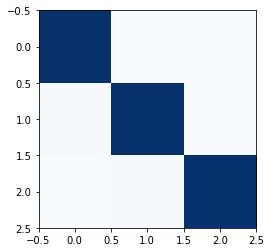

In [15]:
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=512,
          epochs=25,
          verbose=1,
          validation_data=(x_test,y_test)
         )
#Result report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_raw = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_raw, y_pred)
print(cm)
print(classification_report(y_test_raw, y_pred))
plt.imshow(cm, cmap=plt.cm.Blues)

### Model Demo

### Create an audio file for prediction

##### From live recording

###### Run the cell and start talking for 5 seconds, once the time is passed the array 'myrec' will be filled with the values and the cell below can be run

In [ ]:
#This cell will start a recording of 5 times the secondStep declared, in this case just 5 seconds
myrec = sd.rec(int(secondStep * rate * 7), samplerate=rate, channels=2)

##### Or from presaved data

In [ ]:
#_, myrec   = wav.read('Data\\Audio\\Validation\\PietroTest.wav')

##### original sound:

In [ ]:
ipd.Audio(myrec[:,0],rate=rate)

##### this cell will split myrec, preprocess every sample and predict each sample, then the mode of the prediction is taken as our guess 

In [ ]:
ipd.Audio(getPrediction(myrec),rate=rate)


#### We can use this cell to run a live demo

In [19]:
winLen = 7
winPred = np.full(winLen,3, dtype = np.int8)
try:
    while True:
        myrec = sd.rec(int(secondStep * rate), samplerate=rate, channels=1)[:,0]
        time.sleep(secondStep + .1)
        pred = getPrediction(myrec,'value')
        winPred = np.roll(winPred,-1)
        winPred[(winLen-1)] = pred
        name = labels[np.argmax(np.bincount(winPred))]
        print('\rLast ',winLen,' seconds prediction: ',winPred,'Last speaker: ',name, end='             ')
except KeyboardInterrupt:
    pass

Last  7  seconds prediction:  [1 1 1 1 1 1 1] Last speaker:  Putin               

#### The model is also acceptable robust to all sort of disturbed sound

In [ ]:
myrec   = sd.rec(int(secondStep * rate * 7), samplerate=rate, channels=2)

In [ ]:
ipd.Audio(myrec[:,0],rate=rate)

In [ ]:
#Light Noise
audioAugmented   = preprocessAudio(myrec)
audioAugmented    = audioAugmented + np.random.uniform(0,0.02) *np.random.normal(0,1,len(audioAugmented))

ipd.Audio(getPrediction(audioAugmented, 'audio'),rate=rate)

In [ ]:
#Heavy Noise
audioAugmented   = preprocessAudio(myrec)
audioAugmented    = audioAugmented + np.random.uniform(0,0.1) *np.random.normal(0,1,len(audioAugmented))

ipd.Audio(getPrediction(audioAugmented, 'audio'),rate=rate)

In [ ]:
#Moderate noise with negative time stretch and pitch shift 
audioAugmented   = preprocessAudio(myrec)
audioAugmented    = audioAugmented + np.random.uniform(0,0.05) *np.random.normal(0,1,len(audioAugmented))
audioAugmented    = librosa.effects.time_stretch(audioAugmented,0.8)
audioAugmented    = librosa.effects.pitch_shift(audioAugmented,rate,n_steps=-2)

ipd.Audio(getPrediction(audioAugmented,'audio'),rate=rate)

In [ ]:
#Moderate noise with positive time stretch and pitch shift 
audioAugmented   = preprocessAudio(myrec)
audioAugmented    = audioAugmented + np.random.uniform(0,0.05) *np.random.normal(0,1,len(audioAugmented))
audioAugmented    = librosa.effects.time_stretch(audioAugmented,1.2)
audioAugmented    = librosa.effects.pitch_shift(audioAugmented,rate,n_steps=+2)

ipd.Audio(getPrediction(audioAugmented,'audio'),rate=rate)